In [1]:
from data.custom import CustomTrain, CustomTest
from models.vqgan import VQMultiModel
from models.vit import DifficultyViT, NDPViT
from data.utils import custom_collate
import torch

tokenizer = VQMultiModel.load_from_checkpoint("./imagenet_256/vqgan_32768_16/epoch=39-step=480464.ckpt", n_embed=8192)
tokenizer.to("cuda")
tokenizer.eval()

ndpvit = NDPViT.load_from_checkpoint("imagenet_256/ndpvit_b/epoch=89-step=112680.ckpt", vocab_size=32832, resolutions=[1, 2, 4, 8, 16], hidden_dim=1024, depth=16, heads=16, mlp_dim=2048, dim_head=64)
ndpvit.to("cuda")
ndpvit.eval()




/mnt/ndp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/ndp/.venv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/mnt/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


NDPViT(
  (token_embedding): Embedding(32832, 1024)
  (transformer): AdaLNTransformer(
    (layers): ModuleList(
      (0-15): 16 x ModuleList(
        (0): AdaLNAttention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (ada_lin): Sequential(
            (0): SiLU()
            (1): Linear(in_features=1024, out_features=3072, bias=True)
          )
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (1): AdaLNFeedForward(
          (net): Sequential(
            (0): Linear(in_features=1024, out_features=2048, bias=True)
            (1): GELU(approximate='none')
            (2): Linear(in_features=2048, out_features=1024, bias=True)
          )
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (drop_path): Identity()
          (ada_lin): Sequential(
            (0): SiLU()
            (1): Linear(in_fe

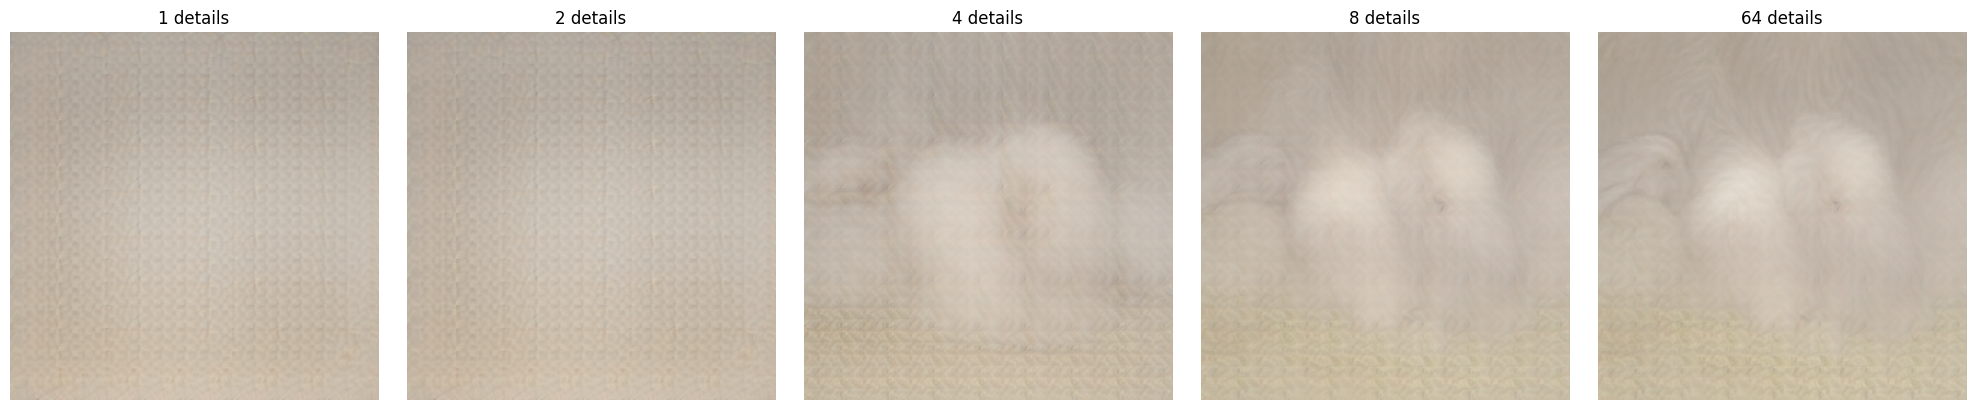

In [ ]:
import matplotlib.pyplot as plt

tokens = torch.zeros((1, 340), dtype=torch.long, device="cuda")
uncond_tokens = torch.zeros((1, 340), dtype=torch.long, device="cuda")
labels = torch.tensor([207], device="cuda")
uncond_labels = torch.full_like(labels, 1000)
tokens = torch.cat([labels.unsqueeze(1), tokens], dim=1)

uncond_tokens = torch.cat([uncond_labels.unsqueeze(1), uncond_tokens], dim=1)
idx = 0

def generate_next_detail(tokens, level_idx):
    # Get all indices for current level
    level_start, level_end = ndpvit.LEVEL_RANGES[level_idx]
    available_indices = []
    for i in range(level_start, level_end):
        subpatch_indices = ndpvit.get_subpatch_indices(i)
        if torch.all(tokens[0, subpatch_indices] == 0) and tokens[0, i] != 0:
            available_indices.append(i)
            
    if not available_indices:
        return tokens, level_idx + 1  # Move to next level
        
    # Randomly select 4 indices from available positions
    num_patches = min(4, len(available_indices))
    selected_idxs = available_indices[:num_patches] # Take first num_patches indices
    
    # Get subpatch indices for all selected indices
    all_subpatch_indices = []
    for idx in selected_idxs:
        subpatch_indices = ndpvit.get_subpatch_indices(idx)
        all_subpatch_indices.extend(subpatch_indices)
    
    # Mark all subpatch indices as masked
    tokens[0, all_subpatch_indices] = 1
    
    # Forward pass for conditioned and unconditioned tokens
    logits = ndpvit.forward(tokens.to("cuda"))
    uncond_logits = ndpvit.forward(uncond_tokens.to("cuda"))

    # Merge conditioned and unconditioned logits
    guidance_scale = 1.0
    logits = (1+guidance_scale)*logits - guidance_scale*uncond_logits

    # Determine valid token range based on hierarchical level
    if level_idx == 0:  # 2x2 level
        valid_range = (64, 64 + 8192)
    elif level_idx == 1:  # 4x4 level
        valid_range = (64 + 8192, 64 + 8192 + 8192)
    elif level_idx == 2:  # 8x8 level
        valid_range = (64 + 8192 + 8192, 64 + 8192 + 8192 + 8192)
    else:  # 16x16 level
        valid_range = (64 + 8192 + 8192 + 8192, 64 + 8192 + 8192 + 8192 + 8192)

    # Mask logits outside the valid range
    logits_masked = logits[0, all_subpatch_indices].clone()
    logits_masked[:, :valid_range[0]] = float('-inf')
    logits_masked[:, valid_range[1]:] = float('-inf')

    # Temperature sampling
    temperature = 1.0
    logits_masked = logits_masked / temperature

    # Top-k sampling
    k = 25
    probs = torch.softmax(logits_masked, dim=-1)
    top_k_probs, top_k_indices = torch.topk(probs, k, dim=-1)
    top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
    sampled_indices = torch.multinomial(top_k_probs, num_samples=1).squeeze(-1)
    sampled_tokens = top_k_indices[torch.arange(len(sampled_indices)), sampled_indices]

    # Place the sampled tokens
    tokens[0, all_subpatch_indices] = sampled_tokens.to(dtype=tokens.dtype, device=tokens.device)

    return tokens, level_idx

output = []
level_idx = 0  # Start from level 0 (class token)
total_details = 0

while level_idx < 5 and total_details < 64:  # 5 is number of levels
    tokens, new_level_idx = generate_next_detail(tokens, level_idx)
    
    if new_level_idx != level_idx:  # We've completed current level
        level_idx = new_level_idx
    
    total_details += 4  # Increment by 4 since we're predicting 4 patches at once
    
    if total_details in [4, 8, 16, 32, 64]:  # Plot at 4, 8, 16, 32, 64 details
        with torch.no_grad():
            # Handle final offsets for each level
            level1_tokens = torch.where(tokens[0, 1:5] != 0, tokens[0, 1:5] - 64, tokens[0, 1:5])
            level2_tokens = torch.where(tokens[0, 5:21] != 0, tokens[0, 5:21] - (64 + 8192), tokens[0, 5:21])
            level3_tokens = torch.where(tokens[0, 21:85] != 0, tokens[0, 21:85] - (64 + 8192 + 8192), tokens[0, 21:85])
            level4_tokens = torch.where(tokens[0, 85:341] != 0, tokens[0, 85:341] - (64 + 8192 + 8192 + 8192), tokens[0, 85:341])

            # Convert to codebook entries
            q1 = tokenizer.quantize_1.get_codebook_entry(level4_tokens.to("cuda"), (1, 16, 16, 8))
            q2 = tokenizer.quantize_2.get_codebook_entry(level3_tokens.to("cuda"), (1, 8, 8, 8))
            q3 = tokenizer.quantize_3.get_codebook_entry(level2_tokens.to("cuda"), (1, 4, 4, 8))
            q4 = tokenizer.quantize_4.get_codebook_entry(level1_tokens.to("cuda"), (1, 2, 2, 8))

            # Decode image
            img = tokenizer.decode(q1, q2, q3, q4)
            output.append(img)

num_imgs = len(output)
fig, axes = plt.subplots(1, num_imgs, figsize=(4*num_imgs, 4))
for i, img in enumerate(output):
    img = torch.clamp(img[0], -1, 1)
    img = (img + 1) / 2
    axes[i].imshow(img.permute(1,2,0).cpu().numpy())
    axes[i].axis('off')
    axes[i].set_title(f'{2**i if i<4 else 64} details')
plt.tight_layout()
plt.show()
